In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def norm(x,p):
    s = np.sum(np.abs(x)**p)
    return s**(1/p)

In [53]:
nd = 5
dvec = 2**np.linspace(2,nd,nd-1,dtype=np.int64)
dvec

array([ 4,  8, 16, 32], dtype=int64)

In [65]:
iter1 = 50
iter2 = 50
p = 1.01
q = p/(p-1)

nd = 8
dvec = 2**np.linspace(1,nd,nd-1,dtype=np.int64)
lend = nd-1

vals = np.zeros(lend)
for k in range(lend):

    d = dvec[k]

    curr = 0

    for i in range(iter1):
        ## define hyperplane
        v = np.random.normal(0,1,size=d)
        v = v/norm(v,2)
        vq = norm(v,q)

        for j in range(iter2):
            x = np.random.normal(0,1,size=d)

            # compute orthogonal projection
            y = np.dot(x,v)*v

            # measure Lp distance
            fake = norm(y,p)

            # measure true distance
            true = np.abs(np.dot(x,v))/vq

            if fake/true > curr:
                curr = fake/true
    vals[k] = curr

            

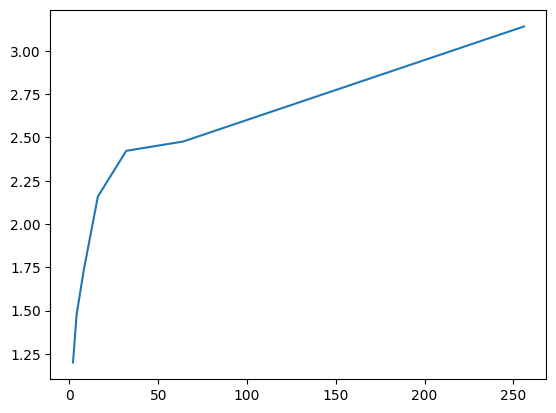

In [66]:
plt.plot(dvec,vals)